# Module 5 - Modern Portfolio Theory

In this module, We’ll be looking at investment portfolio optimization with python, the
fundamental concept of diversification and the creation of an efficient frontier that can be used by investors to choose
specific mixes of assets based on investment goals; that is, the trade off between their desired level of portfolio
return vs their desired level of portfolio risk.

[Modern Portfolio Theory](https://www.investopedia.com/terms/m/modernportfoliotheory.asp) suggests that it is possible to 
construct an "efficient frontier" of optimal portfolios,
offering the maximum possible expected return for a given level of risk. It suggests that it is not enough to look at
the expected risk and return of one particular stock. By investing in more than one stock, an investor can reap the
benefits of diversification, particularly a reduction in the riskiness of the portfolio. MPT quantifies the benefits of
diversification, also known as not putting all of your eggs in one basket.

In [1]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import glob
import random
import skopt
# from skopt import gp_minimize

## Problem Statements

## 5.1 - Annualized Volatility and Returns
For your chosen stock, calculate the mean daily return and daily standard deviation of returns, and then just annualise them to get mean expected annual return and volatility of that single stock. ( annual mean = daily mean * 252 , annual stdev = daily stdev * sqrt(252) )

In [2]:
def read_csv( filename ):
    if isinstance(filename, pd.DataFrame): return filename  # OPTIMIZATION: allow passthrough of existing dataframe
    
    dataframe = pd.read_csv( filename, parse_dates=['Date'] )
    dataframe.set_index( dataframe.Date, inplace=True )
    return dataframe

def meanDailyReturn( filename ):
    return read_csv( filename ).Close_Price.pct_change().dropna().mean()

def meanDailySTD( filename ):
    return read_csv( filename ).Close_Price.pct_change().dropna().std()

def meanAnnualReturn( filename ):
    return meanDailyReturn(filename) * 252

def meanAnnualSTD( filename ):
    return meanDailySTD(filename) * np.sqrt(252)

def getName( filename ):
    return re.sub(r'^.+/|\.[^.]+$',     '',    filename)

def getCap( filename ):
    return re.sub(r'^.*/(\w+_Cap)/.*$', '\\1', filename)

def calcReturnVolatility( filename ):
    input  = read_csv( filename )
    output = DataFrame([{
        "Name":             getName( filename ),
        "Cap":              getCap(  filename ),
        "meanDailyReturn":  meanDailyReturn( input ),
        "meanDailySTD":     meanDailySTD( input ),
        "meanAnnualReturn": meanAnnualReturn( input ),
        "meanAnnualSTD":    meanAnnualSTD( input )
    }])
    output.set_index( output.Name, inplace=True, drop=False )
    return output

stock = '../../data_output/module_1/python3/stocks/Large_Cap/ADANIPORTS.csv'
calcReturnVolatility(stock)

,Name,Cap,meanDailyReturn,meanDailySTD,meanAnnualReturn,meanAnnualSTD
Name,,,,,,
ADANIPORTS,ADANIPORTS,Large_Cap,0.00024,0.019512,0.060499,0.309751


## 5.2 - Covariance Matrix
Now, we need to diversify our portfolio. Build your own portfolio by choosing any 5 stocks, preferably of different sectors and different caps. Assume that all 5 have the same weightage, i.e. 20% . Now calculate the annual returns and volatility of the entire portfolio ( Hint : Don't forget to use the covariance )

In [3]:
filenames_all = glob.glob('../../data_output/module_1/python3/stocks/**/*.csv')
filenames     = random.sample( filenames_all, 5 )

summary_all   = pd.concat([ calcReturnVolatility(stock) for stock in filenames_all ])
summary       = pd.concat([ calcReturnVolatility(stock) for stock in filenames     ])
summary

,Name,Cap,meanDailyReturn,meanDailySTD,meanAnnualReturn,meanAnnualSTD
Name,,,,,,
HINDUNILVR,HINDUNILVR,Large_Cap,0.001188,0.012223,0.299378,0.194041
APOLLOTYRE,APOLLOTYRE,Mid_Cap,-0.000255,0.019556,-0.064303,0.310445
RAYMOND,RAYMOND,Small_Cap,0.000278,0.022919,0.070021,0.363834
MINDTREE,MINDTREE,Mid_Cap,0.001558,0.021512,0.392570,0.341485
NBCC,NBCC,Mid_Cap,-0.002044,0.032043,-0.515176,0.508672


In [4]:
portfolio = DataFrame()
for filename in filenames:
    portfolio[ getName(filename) ] = read_csv(filename).Close_Price
portfolio.head()

,HINDUNILVR,APOLLOTYRE,RAYMOND,MINDTREE,NBCC
Date,,,,,
2017-05-15,983.25,231.90,772.80,509.45,197.60
2017-05-16,1000.40,234.40,785.00,511.30,198.25
2017-05-17,1009.40,237.35,783.65,506.35,200.35
2017-05-18,990.25,232.65,746.95,492.90,194.20
2017-05-19,1008.00,234.65,723.10,497.50,193.55


In [5]:
equal_weights = np.full( portfolio.shape[1], 1/portfolio.shape[1] )
equal_weights

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [6]:
# Portfolio Mean Average Return can be calculated either from: the summary data or the portfolio table
def portfolio_annual_returns(portfolio, weights):
    return np.sum( portfolio.pct_change().mean() * weights ) * 252  

round( portfolio_annual_returns(portfolio, equal_weights), 2 )

0.04

In [7]:
# Portfolio Covarence matrix
portfolio_covarence = portfolio.pct_change().cov()
portfolio_covarence

,HINDUNILVR,APOLLOTYRE,RAYMOND,MINDTREE,NBCC
HINDUNILVR,0.000149,0.000050,0.000039,0.000014,0.000042
APOLLOTYRE,0.000050,0.000382,0.000167,0.000020,0.000144
RAYMOND,0.000039,0.000167,0.000525,0.000041,0.000133
MINDTREE,0.000014,0.000020,0.000041,0.000463,0.000023
NBCC,0.000042,0.000144,0.000133,0.000023,0.001027


In [8]:
def portfolio_annual_volatility( portfolio, weights ): 
    return np.sqrt(
        np.dot( 
            weights.T, 
            np.dot( portfolio.pct_change().cov(), weights )
        ) 
        * np.sqrt(252)
    )

round( portfolio_annual_volatility(portfolio, equal_weights), 2 )

0.05

In [9]:
def portfolio_sharpe( portfolio, weights ): 
    return portfolio_annual_returns( portfolio, weights ) / portfolio_annual_volatility( portfolio, weights )

round( portfolio_sharpe(portfolio, equal_weights), 2 )

0.73

In [10]:
print("Portfolio Annualized Mean Return: ", round( portfolio_annual_returns(    portfolio, equal_weights ), 2) )
print("Portfolio Annualized Volatility:  ", round( portfolio_annual_volatility( portfolio, equal_weights ), 2) )

Portfolio Annualized Mean Return:  0.04
Portfolio Annualized Volatility:   0.05


## 5.3 + 5.4 - Monty-Carlo Simulation

Prepare a scatter plot for differing weights of the individual stocks in the portfolio , the axes being the returns and volatility. Colour the data points based on the Sharpe Ratio ( Returns/Volatility) of that particular portfolio.

Mark the 2 portfolios where:
- Portfolio 1 - The Sharpe ratio is the highest 
- Portfolio 2 - The volatility is the lowest.

In [11]:
def normalize_weights( weights ):
    for i in range(0,3):
        weights  = np.round( weights, 3 ) 
        weights /= weights.sum()
    return np.asarray(weights)
    
def random_weights():
    weights  = np.random.rand(portfolio.shape[1])
    return normalize_weights( weights )

random_weights()

array([0.37 , 0.08 , 0.173, 0.032, 0.345])

In [12]:
scatter_data = DataFrame()
for i in range(0, 2500):
    weights    = random_weights()
    returns    = portfolio_annual_returns(    portfolio, weights )
    volatility = portfolio_annual_volatility( portfolio, weights )
    sharpe     = returns / volatility
    scatter_data = scatter_data.append([{
        "weights":    weights,
        "returns":    returns,
        "volatility": volatility,
        "sharpe":     sharpe
    }])

scatter_data.reset_index(inplace=True, drop=True)
scatter_data.head()

,weights,returns,volatility,sharpe
0,"[0.18000000000000002, 0.28200000000000003, 0.1...",0.080900,0.047871,1.689959
1,"[0.539, 0.297, 0.161, 0.002, 0.001]",0.153810,0.045367,3.390345
2,"[0.23676323676323677, 0.25674325674325676, 0.1...",-0.049019,0.055077,-0.890020
3,"[0.046, 0.207, 0.195, 0.283, 0.269]",-0.013370,0.057044,-0.234385
4,"[0.278, 0.263, 0.124, 0.294, 0.041]",0.169291,0.044174,3.832414


Mark the 2 portfolios where:
- Portfolio 1 - The Sharpe ratio is the highest 
- Portfolio 2 - The volatility is the lowest.

In [13]:
point_max_sharpe     = scatter_data.loc[ scatter_data['sharpe'].idxmax()     ]
point_max_sharpe

weights       [0.556, 0.057, 0.1, 0.275, 0.012]
returns                                0.271566
volatility                            0.0409205
sharpe                                  6.63642
Name: 329, dtype: object

In [14]:
point_min_volatility = scatter_data.loc[ scatter_data['volatility'].idxmin() ]
point_min_volatility

weights       [0.512, 0.139, 0.063, 0.199, 0.087]
returns                                  0.182056
volatility                              0.0401681
sharpe                                    4.53235
Name: 2183, dtype: object

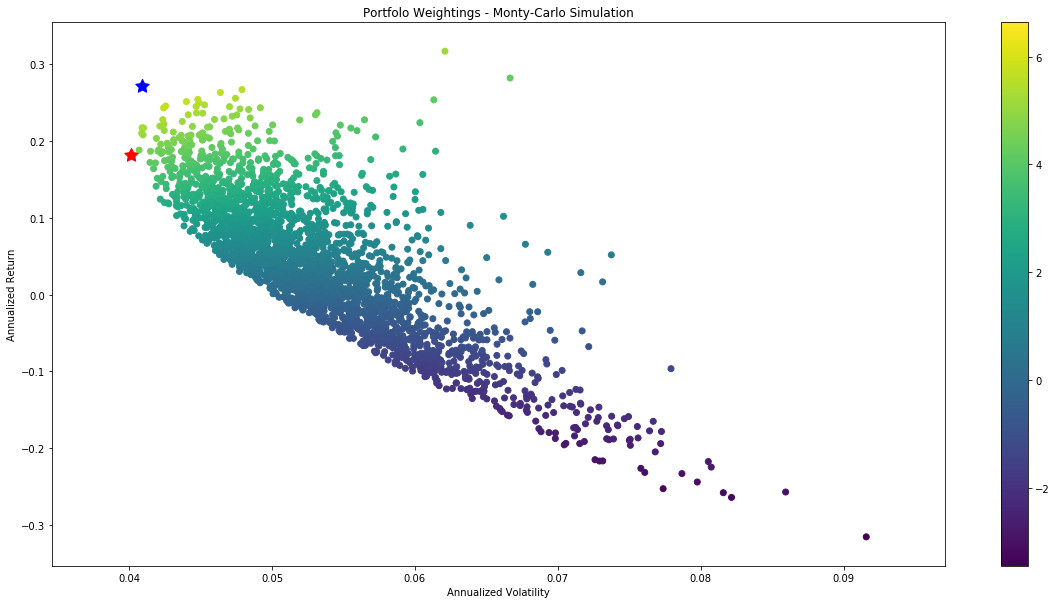

In [15]:
fig, ax = plt.subplots(figsize=(20, 10), nrows=1, ncols=1)
plt.scatter( 
    scatter_data.volatility,     
    scatter_data.returns, 
    c = scatter_data.sharpe
)
plt.title('Portfolo Weightings - Monty-Carlo Simulation')
plt.ylabel('Annualized Return')
plt.xlabel('Annualized Volatility')
plt.colorbar()

# Mark the 2 portfolios where
plt.scatter( point_max_sharpe.volatility,     point_max_sharpe.returns,     marker=(5,1,0), c='b', s=200 )
plt.scatter( point_min_volatility.volatility, point_min_volatility.returns, marker=(5,1,0), c='r', s=200 )

---
# Scikit-Optimize

Mark the 2 portfolios where:
- Portfolio 1 - The Sharpe ratio is the highest
- Portfolio 2 - The volatility is the lowest.

In [22]:
# Portfolio 1 - The Sharpe ratio is the highest 
def max_sharpe( weights ):
    weights = normalize_weights(weights)
    sharpe  = portfolio_annual_returns( portfolio, weights ) / portfolio_annual_volatility( portfolio, weights )
    return  -sharpe  # convert maximization for minimization

# DOCS: https://scikit-optimize.github.io/#skopt.gp_minimize
skopt_max_sharpe = skopt.gp_minimize(
    max_sharpe, 
    [(0., 1.),(0., 1.),(0., 1.),(0., 1.),(0., 1.)],  # must be floating point array
    verbose=False,
    n_calls=30,         # the number of evaluations of f 
    n_random_starts=5,  # the number of random initialization points
    random_state=123    # the random seed    
)
print( "Max Sharpe Ratio Value   - skopt:       ", -skopt_max_sharpe.fun )
print( "Max Sharpe Ratio Value   - Monty Carlo: ",  point_max_sharpe.sharpe  )
print( "Max Sharpe Ratio Improvement:           ",  round( abs(-skopt_max_sharpe.fun / point_max_sharpe.sharpe), 2), 'x'  )
print( "Max Sharpe Ratio Weights - skopt:       ",  skopt_max_sharpe.x )
print( "Max Sharpe Ratio Weights - Monty Carlo: ",  point_max_sharpe.weights  )

/Users/jamie/github/scikit-optimize/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/jamie/github/scikit-optimize/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/jamie/github/scikit-optimize/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/jamie/github/scikit-optimize/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/jamie/github/scikit-optimize/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/jamie/github/scikit-optimize/skopt/optimize

Max Sharpe Ratio Value   - skopt:        7.45652084216862
Max Sharpe Ratio Value   - Monty Carlo:  6.636419295116627
Max Sharpe Ratio Improvement:            1.12 x
Max Sharpe Ratio Weights - skopt:        [1.0, 0.0, 0.0, 0.4907451619465253, 0.0]
Max Sharpe Ratio Weights - Monty Carlo:  [0.556 0.057 0.1   0.275 0.012]


In [17]:
# Portfolio 2 - The volatility is the lowest.
def min_volatility( weights ):
    weights    = normalize_weights(weights)
    volatility = portfolio_annual_volatility( portfolio, weights )
    return volatility
    
# DOCS: https://scikit-optimize.github.io/#skopt.gp_minimize
skopt_min_volatility = skopt.gp_minimize(
    min_volatility, 
    [(0., 1.),(0., 1.),(0., 1.),(0., 1.),(0., 1.)],  # must be floating point array
    verbose=False,
    n_calls=30,         # the number of evaluations of f 
    n_random_starts=5,  # the number of random initialization points
    random_state=123    # the random seed        
)
print( "Min Volatility Value   - skopt:       ",  skopt_min_volatility.fun )
print( "Min Volatility Value   - Monty Carlo: ",  point_min_volatility.volatility  )
print( "Min Volatility Weights - skopt:       ",  skopt_min_volatility.x )
print( "Min Volatility Weights - Monty Carlo: ",  point_min_volatility.weights  )

/Users/jamie/github/scikit-optimize/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/jamie/github/scikit-optimize/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Min Volatility Value   - skopt:        0.044443072610776624
Min Volatility Value   - Monty Carlo:  0.040168135243509276
Min Volatility Weights - skopt:        [1.0, 1.0, 0.0, 0.5353483607223448, 0.0]
Min Volatility Weights - Monty Carlo:  [0.512 0.139 0.063 0.199 0.087]


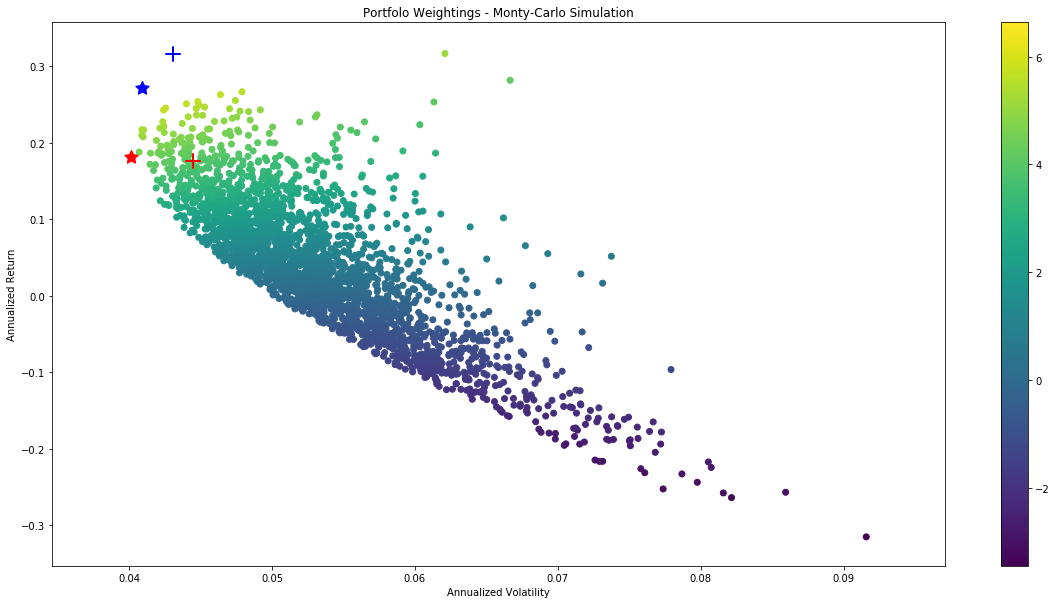

In [18]:
fig, ax = plt.subplots(figsize=(20, 10), nrows=1, ncols=1)
plt.scatter( 
    scatter_data.volatility,     
    scatter_data.returns, 
    c = scatter_data.sharpe
)
plt.title('Portfolo Weightings - Monty-Carlo Simulation')
plt.ylabel('Annualized Return')
plt.xlabel('Annualized Volatility')
plt.colorbar()

# Mark the 2 portfolios where
plt.scatter( point_max_sharpe.volatility,     point_max_sharpe.returns,     marker=(5,1,0), c='b', s=200 )
plt.scatter( point_min_volatility.volatility, point_min_volatility.returns, marker=(5,1,0), c='r', s=200 )
plt.scatter( 
    portfolio_annual_volatility( portfolio, normalize_weights(skopt_max_sharpe.x) ),     
    portfolio_annual_returns(    portfolio, normalize_weights(skopt_max_sharpe.x) ), 
    marker=(4,2,0), c='b', s=200 
)
plt.scatter( 
    portfolio_annual_volatility( portfolio, normalize_weights(skopt_min_volatility.x) ),     
    portfolio_annual_returns(    portfolio, normalize_weights(skopt_min_volatility.x) ), 
    marker=(4,2,0), c='r', s=200 
)

The 4 point +'s mark the skopt optimization points, whereas the 5 point stars represent the mix/max points of the Monty Carlo simulation# 

---
# Analysis of All Stocks

Prepare a scatter plot for differing weights of the individual stocks in the portfolio , the axes being the returns and volatility. Colour the data points based on the Sharpe Ratio ( Returns/Volatility) of that particular portfolio.

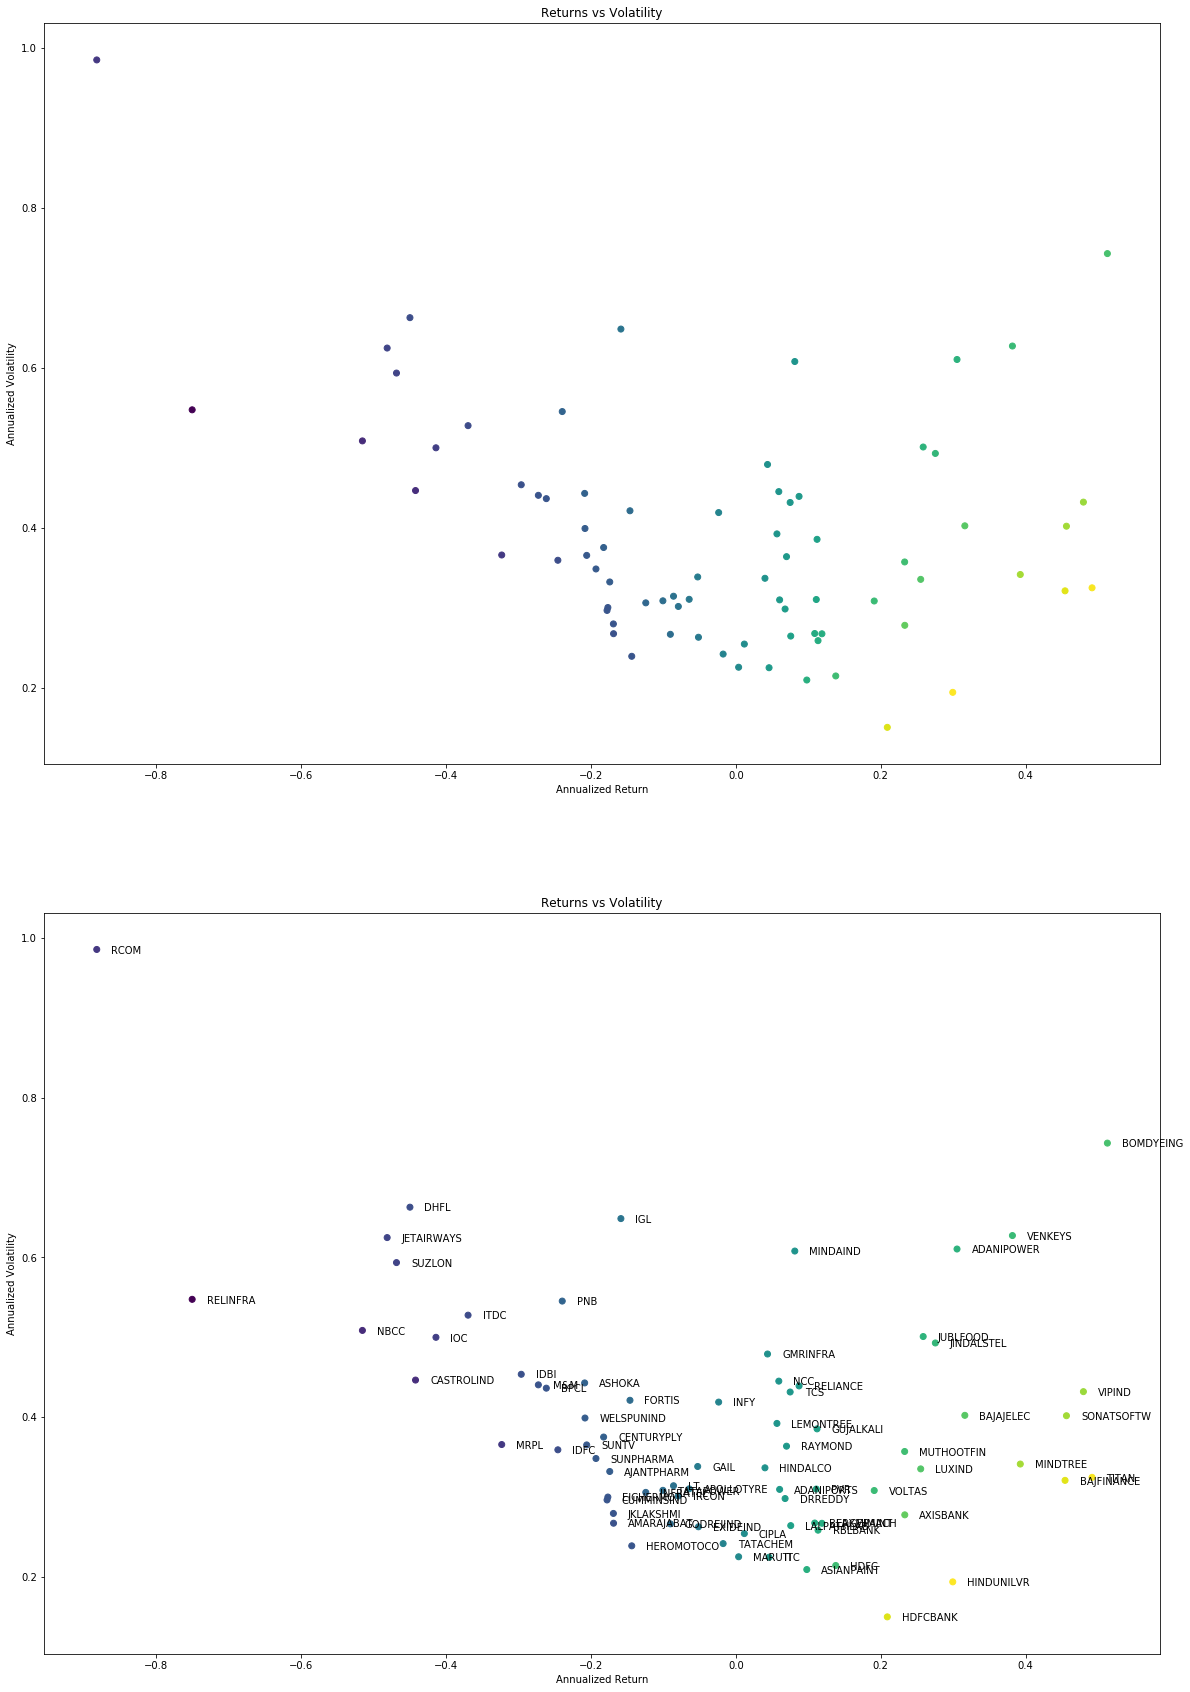

In [19]:
summary_all['Sharpe'] = summary_all.meanAnnualReturn / summary_all.meanAnnualSTD

fig, axes = plt.subplots(figsize=(20, 30), nrows=2, ncols=1)
for n in range(0,2):
    axes[n].scatter( 
        summary_all.meanAnnualReturn, 
        summary_all.meanAnnualSTD, 
        c     = summary_all['Sharpe'],
        label = summary_all['Sharpe']
    )
    axes[n].set_title('Returns vs Volatility')
    axes[n].set_xlabel('Annualized Return')
    axes[n].set_ylabel('Annualized Volatility')

for i in range(0, summary_all.shape[0]):
    axes[n].annotate(summary_all.Name[i], (summary_all.meanAnnualReturn[i]+0.02, summary_all.meanAnnualSTD[i] - 0.005))

Mark the 2 portfolios where:
- Portfolio 1 - The Sharpe ratio is the highest 
- Portfolio 2 - The volatility is the lowest.

In [20]:
portfolio_1 = summary_all.sort_values('Sharpe',ascending=False).head(5)
portfolio_1

,Name,Cap,meanDailyReturn,meanDailySTD,meanAnnualReturn,meanAnnualSTD,Sharpe
Name,,,,,,,
HINDUNILVR,HINDUNILVR,Large_Cap,0.001188,0.012223,0.299378,0.194041,1.542859
TITAN,TITAN,Large_Cap,0.001951,0.020463,0.491593,0.324836,1.513358
BAJFINANCE,BAJFINANCE,Large_Cap,0.001803,0.020225,0.454332,0.321058,1.415107
HDFCBANK,HDFCBANK,Large_Cap,0.000830,0.009465,0.209085,0.150248,1.391600
MINDTREE,MINDTREE,Mid_Cap,0.001558,0.021512,0.392570,0.341485,1.149595


In [21]:
portfolio_2 = summary_all.sort_values('meanAnnualSTD',ascending=True).head(5)
portfolio_2

,Name,Cap,meanDailyReturn,meanDailySTD,meanAnnualReturn,meanAnnualSTD,Sharpe
Name,,,,,,,
HDFCBANK,HDFCBANK,Large_Cap,0.000830,0.009465,0.209085,0.150248,1.391600
HINDUNILVR,HINDUNILVR,Large_Cap,0.001188,0.012223,0.299378,0.194041,1.542859
ASIANPAINT,ASIANPAINT,Large_Cap,0.000389,0.013195,0.097990,0.209462,0.467816
HDFC,HDFC,Large_Cap,0.000547,0.013516,0.137945,0.214557,0.642930
ITC,ITC,Large_Cap,0.000182,0.014165,0.045928,0.224856,0.204255
